In [399]:
import random

from PIL import Image
import urllib

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Tensors

In [9]:
data = [[1.5, 2.6], [3.3, 4.8]]
x_data = torch.tensor(data)

In [18]:
torch.rand_like(x_data, dtype=torch.double)

tensor([[0.7332, 0.5495],
        [0.1107, 0.9675]], dtype=torch.float64)

In [20]:
x_data.shape, x_data.device

(torch.Size([2, 2]), device(type='cpu'))

In [26]:
torch.cat([x_data, x_data.T, x_data])

tensor([[1.5000, 2.6000],
        [3.3000, 4.8000],
        [1.5000, 3.3000],
        [2.6000, 4.8000],
        [1.5000, 2.6000],
        [3.3000, 4.8000]])

In [35]:
x_data.mul(x_data), x_data * x_data, x_data @ x_data.T, x_data.matmul(x_data.T)

(tensor([[ 2.2500,  6.7600],
         [10.8900, 23.0400]]),
 tensor([[ 2.2500,  6.7600],
         [10.8900, 23.0400]]),
 tensor([[ 9.0100, 17.4300],
         [17.4300, 33.9300]]),
 tensor([[ 9.0100, 17.4300],
         [17.4300, 33.9300]]))

In [37]:
x_data.add(5), x_data

(tensor([[6.5000, 7.6000],
         [8.3000, 9.8000]]),
 tensor([[1.5000, 2.6000],
         [3.3000, 4.8000]]))

In [39]:
x_data.add_(5), x_data

(tensor([[6.5000, 7.6000],
         [8.3000, 9.8000]]),
 tensor([[6.5000, 7.6000],
         [8.3000, 9.8000]]))

### Autograd

In [173]:
model = torchvision.models.resnet34(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [174]:
prediction = model(data)

In [175]:
loss = (prediction - labels).sum()
loss.backward(retain_graph=True)

In [176]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [48]:
??torch.optim.SGD

In [177]:
optim.step()

In [178]:
loss

tensor(-480.6505, grad_fn=<SumBackward0>)

In [179]:
loss = (prediction - labels).sum()
loss

tensor(-480.6505, grad_fn=<SumBackward0>)

In [162]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([9., 4.], requires_grad=True)

Q = a**2 + b**2

In [163]:
Q.sum() # (2**2 + 9**2) + (3**2 + 4**2)

tensor(110., grad_fn=<SumBackward0>)

In [161]:
Q.backward(gradient=torch.tensor([1, 1]))
a.grad, b.grad

(tensor([4., 6.]), tensor([18.,  8.]))

In [164]:
Q.backward(gradient=torch.tensor([2, 2]))
a.grad, b.grad

(tensor([ 8., 12.]), tensor([36., 16.]))

### Neural Networks

In [277]:
urllib.request.urlretrieve("https://www.buffalo.edu/content/www/eub/ub_at_a_glance/jcr:content/par/image_1407867871.img.447.260.jpg/1560457710562.jpg", "sample.png")

('sample.png', <http.client.HTTPMessage at 0x7fb5b7f75670>)

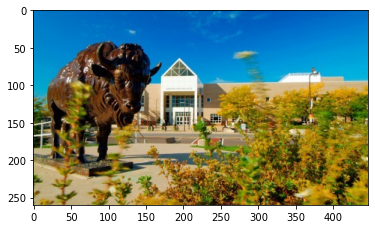

In [376]:
img = PIL.Image.open("sample.png")
plt.imshow(img)

img = torch.from_numpy(np.asarray(img, dtype="float32"))
conv2 = nn.Conv2d(3, 2, kernel_size=3, stride=1, padding=1)

In [377]:
img = img.permute(2, 0, 1)
img.shape

torch.Size([3, 260, 447])

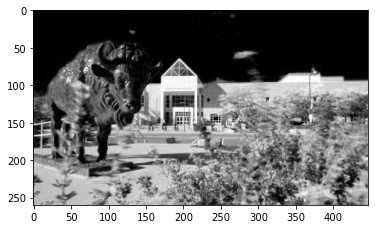

In [378]:
plt.imshow(img[0], cmap='gray')

In [379]:
img_conv = conv2(img.unsqueeze(0))
img_conv.shape

torch.Size([1, 2, 260, 447])

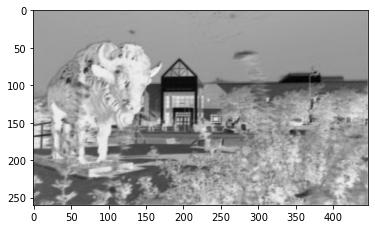

In [385]:
plt.imshow(img_conv[0, 0].detach().numpy().reshape(260, 447), cmap='gray')

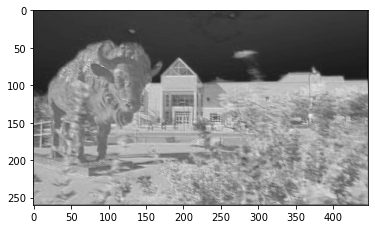

In [386]:
plt.imshow(img_conv[0, 1].detach().numpy().reshape(260, 447), cmap='gray')

In [406]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [407]:
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [408]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [409]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0220, -0.0090, -0.1436,  0.0928, -0.0666, -0.0278, -0.0237,  0.0215,
          0.0764,  0.1253]], grad_fn=<AddmmBackward>)


In [391]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [392]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3579, grad_fn=<MseLossBackward>)


In [393]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [394]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0010, -0.0056, -0.0087,  0.0003, -0.0036, -0.0026])


In [395]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [398]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

### Traning a classifier

In [400]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


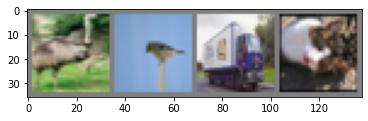

 bird  bird truck   cat


In [401]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [412]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Hyperperameter Tuning

#### Learning Rate: 0.001, momentum=0.9, weight_decay=0.1

In [422]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)

In [423]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.583
[1,  4000] loss: 1.896
[1,  6000] loss: 1.957
[1,  8000] loss: 1.962
[1, 10000] loss: 1.967
[1, 12000] loss: 1.985
[2,  2000] loss: 1.969
[2,  4000] loss: 1.976
[2,  6000] loss: 1.961
[2,  8000] loss: 1.978
[2, 10000] loss: 1.981
[2, 12000] loss: 1.996
Finished Training


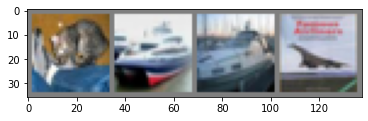

GroundTruth:    cat  ship  ship plane


In [424]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [425]:
outputs = net(images)

In [426]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    car   car   car   car


In [427]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 22 %


In [428]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 47.1 %
Accuracy for class car   is: 89.8 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 13.3 %
Accuracy for class frog  is: 60.7 %
Accuracy for class horse is: 16.5 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %


#### Learning Rate: 0.001, momentum=0.9, weight_decay=0.001

In [429]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [430]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.886
[1,  4000] loss: 1.827
[1,  6000] loss: 1.771
[1,  8000] loss: 1.726
[1, 10000] loss: 1.680
[1, 12000] loss: 1.638
[2,  2000] loss: 1.601
[2,  4000] loss: 1.549
[2,  6000] loss: 1.522
[2,  8000] loss: 1.482
[2, 10000] loss: 1.433
[2, 12000] loss: 1.396
Finished Training


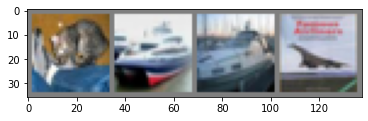

GroundTruth:    cat  ship  ship plane


In [431]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [432]:
outputs = net(images)

In [433]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [434]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


In [435]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 51.5 %
Accuracy for class car   is: 70.0 %
Accuracy for class bird  is: 14.9 %
Accuracy for class cat   is: 6.7 %
Accuracy for class deer  is: 41.5 %
Accuracy for class dog   is: 74.4 %
Accuracy for class frog  is: 66.3 %
Accuracy for class horse is: 56.0 %
Accuracy for class ship  is: 69.3 %
Accuracy for class truck is: 43.2 %


#### Learning Rate: 0.001, momentum=0.9, weight_decay=0, New Network: Added a new fully connected layer

In [485]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)
        self.fc4 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net2 = Net2()
net2

Net2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
)

In [486]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.8)

In [487]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.305
[1,  4000] loss: 2.300
[1,  6000] loss: 2.241
[1,  8000] loss: 2.037
[1, 10000] loss: 1.888
[1, 12000] loss: 1.757
[2,  2000] loss: 1.679
[2,  4000] loss: 1.629
[2,  6000] loss: 1.575
[2,  8000] loss: 1.497
[2, 10000] loss: 1.459
[2, 12000] loss: 1.452
Finished Training


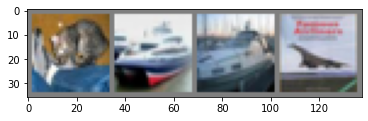

GroundTruth:    cat  ship  ship plane


In [490]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [492]:
outputs = net2(images)

In [493]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [494]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [495]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 41.8 %
Accuracy for class car   is: 76.3 %
Accuracy for class bird  is: 27.1 %
Accuracy for class cat   is: 35.7 %
Accuracy for class deer  is: 48.4 %
Accuracy for class dog   is: 46.8 %
Accuracy for class frog  is: 54.6 %
Accuracy for class horse is: 50.3 %
Accuracy for class ship  is: 62.0 %
Accuracy for class truck is: 44.6 %
